# Training a FeedForward network using Improved Animal Migraiton Optimization

This proyect is based on the following paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8578534/

and we will be using the following dataset: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [1]:
# libraries used in the proyect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random as r
import math
from tqdm.auto import tqdm

In [2]:
file = "realtor-data.csv"
data = pd.read_csv(file)

In [3]:
data

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
99995,for_sale,3.0,3.0,NaN,Hudson,Massachusetts,1749.0,2864.0,NaN,749900.0
99996,for_sale,2.0,1.0,0.34,Auburn,Massachusetts,1501.0,1075.0,1999-06-07,349900.0
99997,for_sale,3.0,2.0,1.01,Shrewsbury,Massachusetts,1545.0,1632.0,1995-09-27,549000.0
99998,for_sale,3.0,2.0,0.12,Worcester,Massachusetts,1604.0,1332.0,2000-09-11,299000.0


We can see that we are missing some information in some rows, we are going to filter out those so we can make a fair comparision between the two networks we are going to train

In [4]:
data = data.drop(['prev_sold_date'],axis=1)
data = data.dropna()

We codify the states and cities replacing the string for a number unique for each state or city

In [5]:
status = {'for_sale':1, 'ready_to_build':0}
city = {k: v for v, k in enumerate(data.city.unique())}
state = {k: v for v, k in enumerate(data.state.unique())}
data = data.replace({'status':status})
data = data.replace({'city':city})
data = data.replace({'state':state})
data

,status,bed,bath,acre_lot,city,state,zip_code,house_size,price
0,1,3.0,2.0,0.12,0,0,601.0,920.0,105000.0
1,1,4.0,2.0,0.08,0,0,601.0,1527.0,80000.0
2,1,2.0,1.0,0.15,1,0,795.0,748.0,67000.0
3,1,4.0,2.0,0.10,2,0,731.0,1800.0,145000.0
5,1,4.0,3.0,0.46,3,0,612.0,2520.0,179000.0
...,...,...,...,...,...,...,...,...,...
99994,1,2.0,2.0,1.40,242,2,1562.0,1225.0,385000.0
99996,1,2.0,1.0,0.34,232,2,1501.0,1075.0,349900.0
99997,1,3.0,2.0,1.01,255,2,1545.0,1632.0,549000.0
99998,1,3.0,2.0,0.12,244,2,1604.0,1332.0,299000.0


We separate the expected value from the rest of the data

In [6]:
originalY = data['price']
originalX = data.drop(['price'],axis=1)

In [7]:
minPrice = originalY.min()
maxPrice = originalY.max()
normalizedY = (originalY - minPrice) / (maxPrice - minPrice)

 We create the three data sets: validation, training, testing

In [8]:
trnX, valX, trnY, valY = train_test_split(originalX,normalizedY,test_size=0.2)
tstX, valX, tstY, valY = train_test_split(valX,valY,test_size=0.5)

In [9]:
valX

,status,bed,bath,acre_lot,city,state,zip_code,house_size
40649,1,2.0,3.0,30.00,103,2,1007.0,2130.0
70728,1,8.0,5.0,0.50,154,2,1050.0,3100.0
11379,1,7.0,6.0,0.12,81,1,802.0,5077.0
25561,1,3.0,3.0,0.74,45,0,777.0,2200.0
85919,1,3.0,2.0,0.12,244,2,1604.0,1332.0
...,...,...,...,...,...,...,...,...
52795,1,6.0,3.0,0.34,156,2,1201.0,2943.0
83640,1,2.0,2.0,0.45,438,2,1568.0,1492.0
61103,1,7.0,5.0,2.50,103,2,1007.0,2833.0
48694,1,4.0,2.0,0.33,109,2,1040.0,2003.0


In [10]:
valY

40649    0.005334
70728    0.005666
11379    0.021420
25561    0.004001
85919    0.004817
           ...   
52795    0.002750
83640    0.005334
61103    0.006999
48694    0.003584
20204    0.006918
Name: price, Length: 6067, dtype: float64

In [11]:
tstX

,status,bed,bath,acre_lot,city,state,zip_code,house_size
36457,1,3.0,1.0,0.90,90,2,1030.0,1216.0
97534,1,4.0,3.0,2.41,240,2,1590.0,3480.0
81115,1,4.0,4.0,0.82,406,2,1720.0,4121.0
45318,1,5.0,2.0,0.07,263,3,6790.0,2094.0
65175,1,2.0,1.0,0.63,294,2,1266.0,720.0
...,...,...,...,...,...,...,...,...
13405,1,3.0,1.0,0.04,54,0,915.0,786.0
37648,1,7.0,5.0,2.50,103,2,1007.0,2833.0
53692,1,4.0,3.0,2.07,154,2,1050.0,2880.0
80790,1,3.0,2.0,0.55,389,2,1523.0,1566.0


In [12]:
tstY

36457    0.003584
97534    0.012319
81115    0.021502
45318    0.002250
65175    0.004584
           ...   
13405    0.000691
37648    0.006999
53692    0.006484
80790    0.003166
92059    0.006249
Name: price, Length: 6067, dtype: float64

In [13]:
trnX

,status,bed,bath,acre_lot,city,state,zip_code,house_size
11112,1,3.0,2.0,0.10,54,0,926.0,1388.0
83113,1,4.0,3.0,10.67,395,2,1451.0,3581.0
75657,1,5.0,2.0,0.15,373,6,3452.0,1629.0
52282,1,3.0,2.0,1.45,126,3,6238.0,1414.0
31421,1,4.0,1.0,0.11,135,3,6082.0,1260.0
...,...,...,...,...,...,...,...,...
31838,1,4.0,2.0,0.12,109,2,1040.0,1599.0
57068,1,4.0,4.0,217.00,297,5,12017.0,4000.0
98333,1,6.0,4.0,0.53,242,2,1562.0,4123.0
76294,1,12.0,4.0,0.13,128,2,1082.0,4212.0


In [14]:
trnY

11112    0.002884
83113    0.043174
75657    0.004001
52282    0.004749
31421    0.003166
           ...   
31838    0.003416
57068    0.058176
98333    0.011085
76294    0.004832
67124    0.005668
Name: price, Length: 48536, dtype: float64

In [15]:
#Function to convert a pandas data set of expectes values into a tensor with the same values
def yLabel(df):
    aux = []
    for x in df:
        aux += [[x]]
    return torch.tensor(aux).float()

In [16]:
# we transform the data sets into tensors
originalX = torch.tensor(originalX.to_numpy()).float()
originalY = yLabel(originalY)
normalizedY = yLabel(normalizedY)
valX = torch.tensor(valX.to_numpy()).float()
valY = yLabel(valY)
trnX = torch.tensor(trnX.to_numpy()).float()
trnY = yLabel(trnY)
tstX = torch.tensor(tstX.to_numpy()).float()
tstY = yLabel(tstY)

## creacion de la red backpropagation

In [17]:
class neuralNet(nn.Module):
    
    def __init__(self, in_features, hidden_1, hidden_2, out_features):
        
        super(neuralNet,self).__init__()
        # we create the layers of the neural network
        self.fc1 = nn.Linear(in_features = in_features, out_features = hidden_1)
        self.fc2 = nn.Linear(in_features = hidden_1, out_features = hidden_2)
        self.fc3 = nn.Linear(in_features = hidden_2, out_features = out_features)
        
        # we save the value of the sizes for the genetic codification
        self.inSize = in_features
        self.hidden1Size = hidden_1
        self.hidden2Size = hidden_2
        self.outSize = out_features
        self.weightSize = (in_features+1)*hidden_1 \
                        +(hidden_1+1)*hidden_2 \
                        +(hidden_2+1)*out_features
        
        # this will help visualize the learning and make comparisons between models
        self.errorTimeline = []
        
    def forward(self, X):
        # we transform the input into the output by passing the data along each layer
        h1 = torch.sigmoid(self.fc1(X))
        h2 = torch.sigmoid(self.fc2(h1))
        out = torch.sigmoid(self.fc3(h2))
        return out
    
    def buildFromChromosome(self, chromosome):
        # given a representation of the weights of a network we change the current
        #  weights of the network to the ones on the representation
        c =  chromosome.tolist()
        low = 0
        up = self.outSize*self.hidden2Size
        t2 = c[low:up]
        
        low += self.outSize*self.hidden2Size
        up += self.outSize
        b2 = c[low:up]
        
        low += self.outSize
        up += self.hidden2Size*self.hidden1Size
        t1 = c[low:up]
        
        low += self.hidden2Size*self.hidden1Size
        up += self.hidden2Size
        b1 = c[low:up]
        
        low += self.hidden2Size
        up += self.hidden1Size*self.inSize
        t0 = c[low:up]
        
        low += self.hidden1Size*self.inSize
        up += self.hidden1Size
        b0 = c[low:up]
        # we transform the lists into tensors with the shape of the weights and assign them
        with torch.no_grad():
            self.fc1.weight.data = torch.reshape(torch.tensor(t0),self.fc1.weight.data.shape)
            self.fc1.bias.data = torch.reshape(torch.tensor(b0),self.fc1.bias.data.shape)
            self.fc2.weight.data = torch.reshape(torch.tensor(t1),self.fc2.weight.data.shape)
            self.fc2.bias.data = torch.reshape(torch.tensor(b1),self.fc2.bias.data.shape)
            self.fc3.weight.data = torch.reshape(torch.tensor(t2),self.fc3.weight.data.shape)
            self.fc3.bias.data = torch.reshape(torch.tensor(b2),self.fc3.bias.data.shape)

    def train(self, X, Y, optimizer, epoch = 50):
        self.optimizer = optimizer
        for i in tqdm(range(epoch)):
            self.optimizer.zero_grad()
            # We obtain the gradient by backpropagation
            self.errorTimeline += [self.backPropagate(X, Y).item()]
            # we update the weights of the neural network
            self.optimizer.step()
            
    def backPropagate(self,X,Y):
        error = self.error(X,Y)
        # we obtain the error gradient
        error.backward()
        return error

    def error(self,X,Y):
        # we evaluate all the entries to get a prediction
        prediction = self.forward(X)
        # we define the loss function to be minimum square error
        fError= nn.MSELoss()
        # we calculate the error from our prediction and the answer
        return fError(prediction,Y)
    
    def getWeights(self):
        with torch.no_grad():
            return self.fc1.weight.data,self.fc1.bias.data,\
                    self.fc2.weight.data,self.fc2.bias.data,\
                    self.fc3.weight.data,self.fc3.bias.data
    
    def predict(self,inputs):
        # given some inputs we predict an output
        return self.forward(inputs)

In [18]:
# function to save the weights of a neural network into a pth file
def saveNet(neuralNet,route='./weights.pth'):
    torch.save(neuralNet.state_dict(),route)
    
# function to load the weights in a file into a neural network 
def loadNet(neuralNet,route='./weights.pth'):
    neuralNet.load_state_dict(torch.load(route))

In [19]:
def graphError(networks,labels):
    for net,label in zip(networks,labels):
        x = range(len(net.errorTimeline))
        plt.plot(x,net.errorTimeline,label=label)
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.legend()
    plt.show()
    plt.rcParams['figure.dpi'] = 150

In [20]:
net1 = neuralNet(8,8,8,1)
net1.train(trnX,trnY,optim.SGD(net1.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
net2 = neuralNet(8,16,16,1)
net2.train(trnX,trnY,optim.SGD(net2.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
net3 = neuralNet(8,50,50,1)
net3.train(trnX,trnY,optim.SGD(net3.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
net4 = neuralNet(8,100,100,1)
net4.train(trnX,trnY,optim.SGD(net4.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
net5 = neuralNet(8,6,4,1)
net5.train(trnX,trnY,optim.SGD(net5.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
net6 = neuralNet(8,5,2,1)
net6.train(trnX,trnY,optim.SGD(net6.parameters(), lr=0.5),epoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

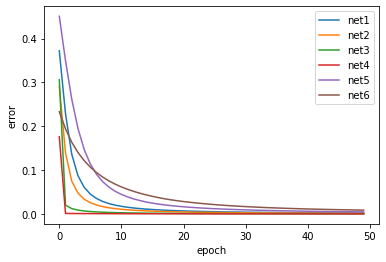

In [26]:
nets = [net1,net2,net3,net4,net5,net6]
labels = ['net1','net2','net3','net4','net5','net6']
graphError(nets,labels)

In [27]:
for net,label in zip(nets,labels):
    print("the error of", label,"with the validation data is:", net.error(valX,valY).item())

the error of net1 with the validation data is: 0.0024777869693934917
the error of net2 with the validation data is: 0.00181428377982229
the error of net3 with the validation data is: 0.0008028129232116044
the error of net4 with the validation data is: 0.0005319794290699065
the error of net5 with the validation data is: 0.005005132872611284
the error of net6 with the validation data is: 0.008851524442434311


In [28]:
net3.weightSize

3051

In [29]:
net4.weightSize

11101

we can see that net4 has the lowest error but it has almost four times as much weights (net3 has 3051 weights and net4 has 11101) so its better to use a network of the shape of "net3" because it will train faster than one of the shape "net4" so we can make more epcochs in less time and aproach net4's results with less computational time

In [30]:
finalNet = neuralNet(8,50,50,1)
finalNet.train(trnX,trnY,optim.SGD(finalNet.parameters(), lr=0.5),epoch=300)

  0%|          | 0/300 [00:00<?, ?it/s]

In [31]:
#saveNet(finalNet,route='./backpropagation.pth') # uncommetn this to save the trained network
loadNet(finalNet,route='./backpropagation.pth') 

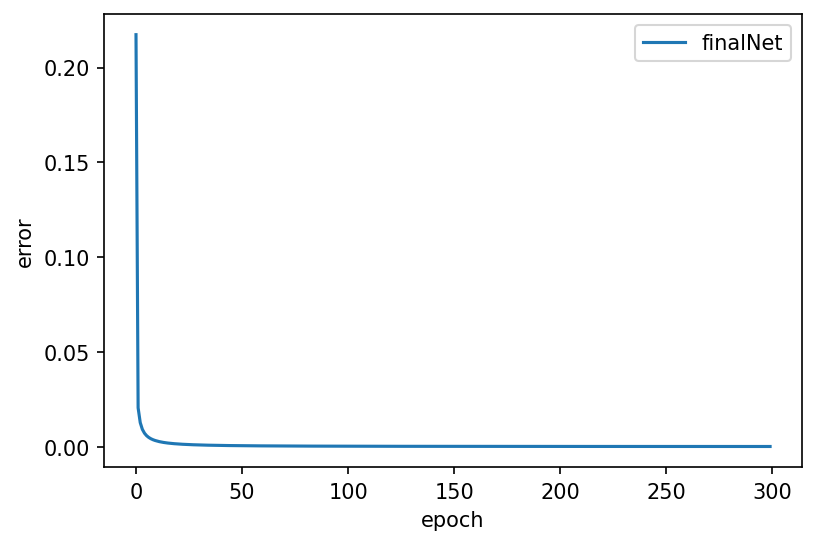

In [32]:
graphError([finalNet],['finalNet'])

In [33]:
print("the error of the network with the test data is:", finalNet.error(tstX,tstY).item())

the error of the network with the test data is: 0.0005430415039882064


In [34]:
# to see how the networks behaves with new data we are going to make buckets to see
# the range of the error for diferent houses, we also will calculate the percentage of how
# close the net was from the real price
predictionsBackP=finalNet.predict(tstX)
avgError = 0
e100 = 0
e1000 = 0
e5000 = 0
e10000 = 0
e50000 = 0
e100000 = 0
e500000 = 0
eMillion = 0
errorByPricePercent = 0
for p,price in zip(predictionsBackP,tstY):
    realPrice = (maxPrice-minPrice)*price.item()+minPrice
    predictedPrice = (maxPrice-minPrice)*p.item()+minPrice
    e = abs(realPrice-predictedPrice)
    avgError += e
    errorByPricePercent += realPrice*100/predictedPrice
    if(e<1000):
        e100 += 1
        continue
    if(e<5000):
        e1000 += 1
        continue
    if(e<10_000):
        e5000 += 1
        continue
    if(e<50_000):
        e10000 += 1
        continue
    if(e<100_000):
        e50000 += 1
        continue
    if(e<500_000):
        e100000 += 1
        continue
    if(e<1_000_000):
        e500000 +=1
        continue
    eMillion += 1
avgError /= len(predictionsBackP)
errorByPricePercent /= len(predictionsBackP)

In [35]:
print("our neural network has an average error of ${:,.2f}".format(avgError))
print("and our predictions are around {}% of the real price".format(errorByPricePercent))

our neural network has an average error of $565,209.47
and our predictions are around 62.8955262628557% of the real price


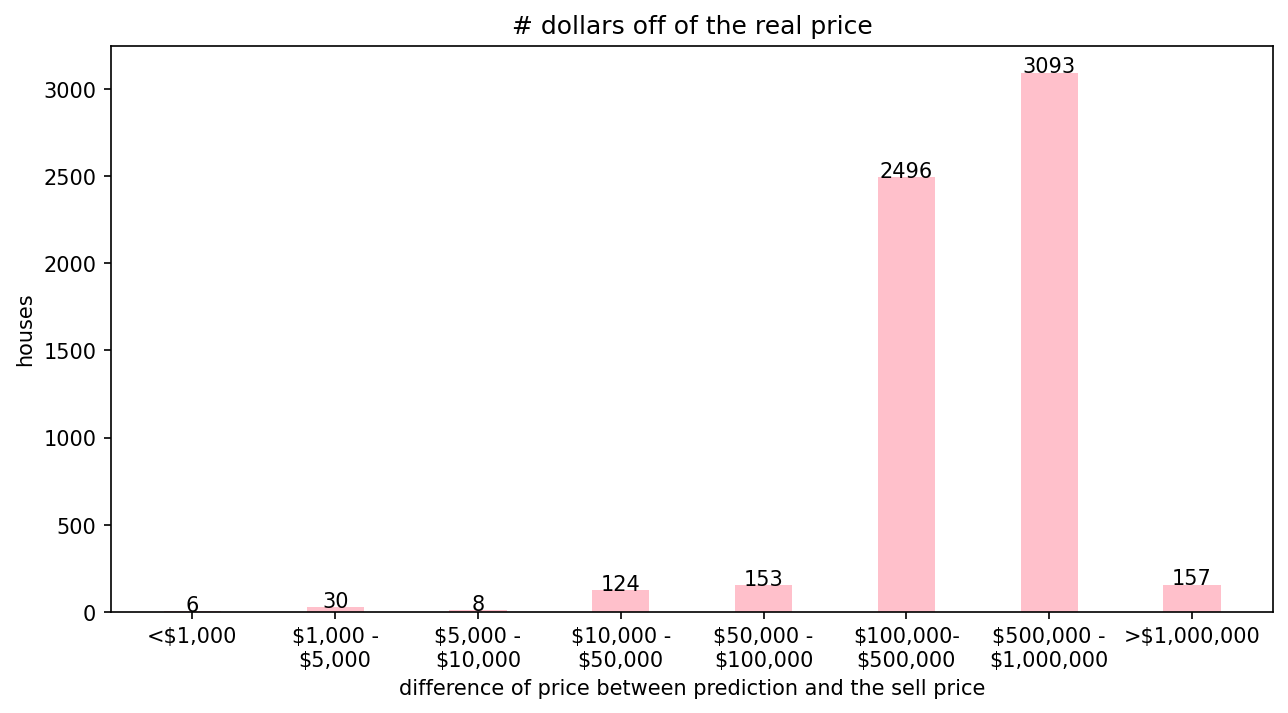

In [36]:
timesBP = [e100,e1000,e5000,e10000,e50000,e100000,e500000,eMillion]
tags = ['<$1,000','$1,000 -\n$5,000','$5,000 -\n$10,000','$10,000 -\n$50,000','$50,000 -\n$100,000','$100,000-\n$500,000','$500,000 -\n$1,000,000','>$1,000,000']
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(tags, timesBP, color ='pink',
        width = 0.4)
for i in range(len(tags)):
    plt.text(i,timesBP[i],timesBP[i],ha='center')
plt.xlabel("difference of price between prediction and the sell price")
plt.ylabel("houses")
plt.title("# dollars off of the real price")
plt.show()

As we can see that the net mostly guesses a price within 100,000 and 500,000 dollars of the real price, but sometimes we guess a price with more than a million dollars of error, we will try to lower this with the help of the Improved Animal Migration Optimization algorithm

## Genetic Model

In [37]:
class individual():
    
    def __init__(self,neuralNet,levy=5):
        chromosome = []
        for _ in range(neuralNet.weightSize): 
            chromosome += [np.random.standard_t(neuralNet.inSize)]
        self.neuralNet = neuralNet
        self.chromosome = np.array(chromosome)
        self.levyCounter = 0
        self.levy = levy
        self.fitness = 10000000000
        self.nextChromosome = None
        
        
    def calculateFitness(self,X,Y):
        # Given a data set of entries X and their expected values Y
        # we calculate the fitness of the next posible solution 
        #(or the current solution for the first iteration)
        # if the fitness of the new position is better we reset the LevyFlight counter
        # and we update the position bia the chromosome
        if self.nextChromosome is not None:
            self.neuralNet.buildFromChromosome(self.nextChromosome)
        else:
            self.neuralNet.buildFromChromosome(self.chromosome)
        newFitness = self.neuralNet.error(X,Y).item()
        if newFitness >= self.fitness:
            self.levyCounter += 1
        else:
            self.levyCounter = 0
            self.fitness = newFitness
            if self.nextChromosome is not None:
                self.chromosome = self.nextChromosome
        
    def migrate(self, neighbor):
        # Given a neighbor we do the migration operation to get the next candidate position
        # if we have passed the Levy Flight counter we do the Levy Flight operation instead
        if self.levyCounter < self.levy:
            cr = neighbor.chromosome
            delta = r.random()
            self.nextChromosome = self.chromosome+delta*(cr-self.chromosome)
        else:
            self.levyCounter = 0
            self.nextChromosome = self.chromosome+self.levyFlight(len(self.chromosome))*self.chromosome
    
    def repopulate(self,best,r1,r2,X,Y):
        # given two random indivuals r1, r2 and the best individual of the population
        # we create a new individual for the next position 
        cb = best.chromosome
        c1 = r1.chromosome
        c2 = r2.chromosome
        rand = r.random()
        self.nextChromosome = c1+rand*(cb-self.chromosome)+rand*(c2-self.chromosome)
            
    def levyFlight(self,D):
        # Given a dimentionality of D we calculate the value of the levyFlight
        beta=1.5
        # we calculate sigma and assigned directly to save up on operations instead of 
        # calculating it each time.
        # with a of beta=1.5 sigma is 0.8565988622835502
        sigma = 0.8565988622835502
        r1 = r.random()
        r2 = r.random()
        return 0.01*(r1*sigma)/(r2**(1/beta))

In [38]:
class IAMO():
    def __init__(self,neuralNet,clusterSize=5,populationSize=50):
        population = []
        for _ in range(populationSize):
            population += [individual(neuralNet)]
        self.population = population
        self.populationSize = populationSize
        self.neuralNet = neuralNet
        self.clusterSize = clusterSize
        self.errorTimeline = []
        
    def train(self,X,Y,epoch = 50):
        for _ in tqdm(range(epoch)):
            # we order the population from best (position 0) to worst (position populationSize))
            self.orderByFitness(X,Y)
            # we do the migtration operation in the population
            self.migrate()
            self.orderByFitness(X,Y)
            # we do the repopulation operation in the population
            self.repopulate(X,Y)
            # we add the fitness of the best individual to graph the error at the end
            self.errorTimeline += [self.population[0].fitness]
        self.orderByFitness(X,Y)
        # after the training we load the best network found
        self.neuralNet.buildFromChromosome(self.population[0].chromosome)
            
    def orderByFitness(self,X,Y):
        # for each individual we calculate its new fitness
        for ind in self.population:
            ind.calculateFitness(X,Y)
        # then we order the population
        self.sortPopulation()
    
    def sortPopulation(self):
         # we order the population from best (position 0) to worst (position populationSize))
        self.population.sort(key=lambda x: x.fitness)
    
    def migrate(self):
        #The migration operators separate the population in clusters
        for clusterIndex in range(int(self.populationSize/self.clusterSize)):
            neighborhood = []
            #first we create the neighborhood 
            for index in range(self.clusterSize):
                neighbor = (clusterIndex*self.clusterSize)+index-int(self.clusterSize/2)
                neighborhood += [self.population[neighbor]]
            # and for each individual in the neighborhood
            for current in range(self.clusterSize):
                neighbor = current
                # we select a diferent individual
                while neighbor == current:
                    neighbor = r.randint(0, self.clusterSize-1)
                # and migrate towards them
                neighborhood[current].migrate(neighborhood[neighbor])
    
    def repopulate(self,X,Y):
        #for each individual we have a probability of them to stay in our herd of 1/p
        # with p being its position given by the fitness
        for i in range(self.populationSize):
            p = 1/(i+1)
            # we calculate a random number to see if this particular individual will undergo
            # the repopulation operator
            if p<r.random():
                best = self.population[0]
                # we assign two random diferent individuals to repopulate (r1,r2)
                r1 = i
                while r1 == i:
                    r1 = r.randint(1,self.populationSize-1)
                r2 = i
                while r2 == i or r2 == r1:
                    r2 = r.randint(1,self.populationSize-1)
                # and we do the repopulation operator
                self.population[i].repopulate(best,self.population[r1],self.population[r2],X,Y)
    
    def predict(self,X):
        # given a set of houses X we predict their prices and return that array
        return self.neuralNet.predict(X)

In [39]:
evoNet = neuralNet(8,50,50,1)
genModel = IAMO(evoNet)

In [40]:
genModel.train(trnX,trnY,epoch=300)

  0%|          | 0/300 [00:00<?, ?it/s]

In [41]:
#saveNet(genModel.neuralNet,route='./iamo.pth') # uncommetn this to save the trained network
loadNet(genModel.neuralNet,route='./iamo.pth')

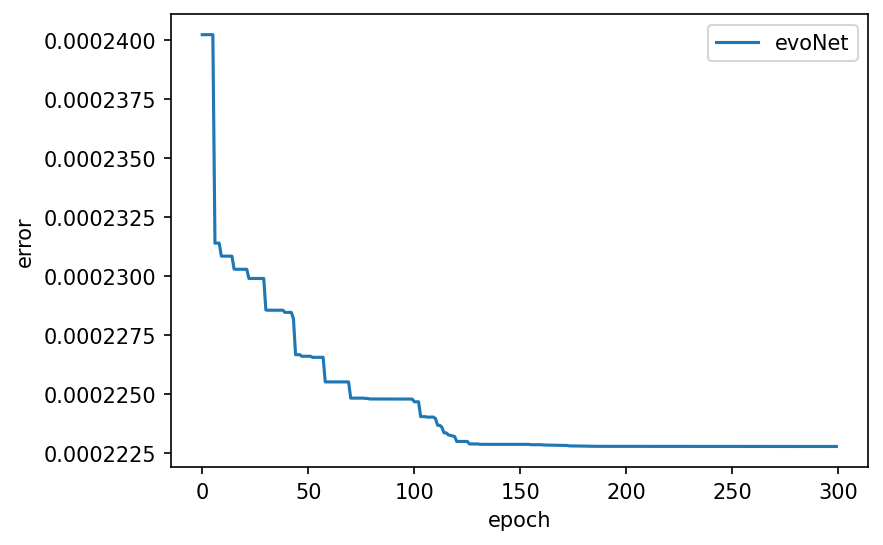

In [42]:
graphError([genModel],['evoNet'])

In [43]:
print("the error of the network with the test data is:", genModel.neuralNet.error(tstX,tstY).item())

the error of the network with the test data is: 0.0004704230814240873


In [44]:
# to see how the networks behaves with new data we are going to make buckets to see
# the range of the error for diferent houses, we also will calculate the percentage of how
# close the net was from the real price
predictionsGen=genModel.predict(tstX)
avgError = 0
e100 = 0
e1000 = 0
e5000 = 0
e10000 = 0
e50000 = 0
e100000 = 0
e500000 = 0
eMillion = 0
for p,price in zip(predictionsGen,tstY):
    realPrice = (maxPrice-minPrice)*price.item()+minPrice
    predictedPrice = (maxPrice-minPrice)*p.item()+minPrice
    e = abs(realPrice-predictedPrice)
    avgError += e
    errorByPricePercent += realPrice*100/predictedPrice
    if(e<1000):
        e100 += 1
        continue
    if(e<5000):
        e1000 += 1
        continue
    if(e<10_000):
        e5000 += 1
        continue
    if(e<50_000):
        e10000 += 1
        continue
    if(e<100_000):
        e50000 += 1
        continue
    if(e<500_000):
        e100000 += 1
        continue
    if(e<1_000_000):
        e500000 +=1
        continue
    eMillion += 1
avgError /= len(predictionsGen)
errorByPricePercent /= len(predictionsGen)

In [45]:
print("our neural network trained with IAMO has an average error of ${:,.2f}".format(avgError))
print("and our predictions are around {}% of the real price".format(errorByPricePercent))

our neural network trained with IAMO has an average error of $318,158.67
and our predictions are around 107.49862641256534% of the real price


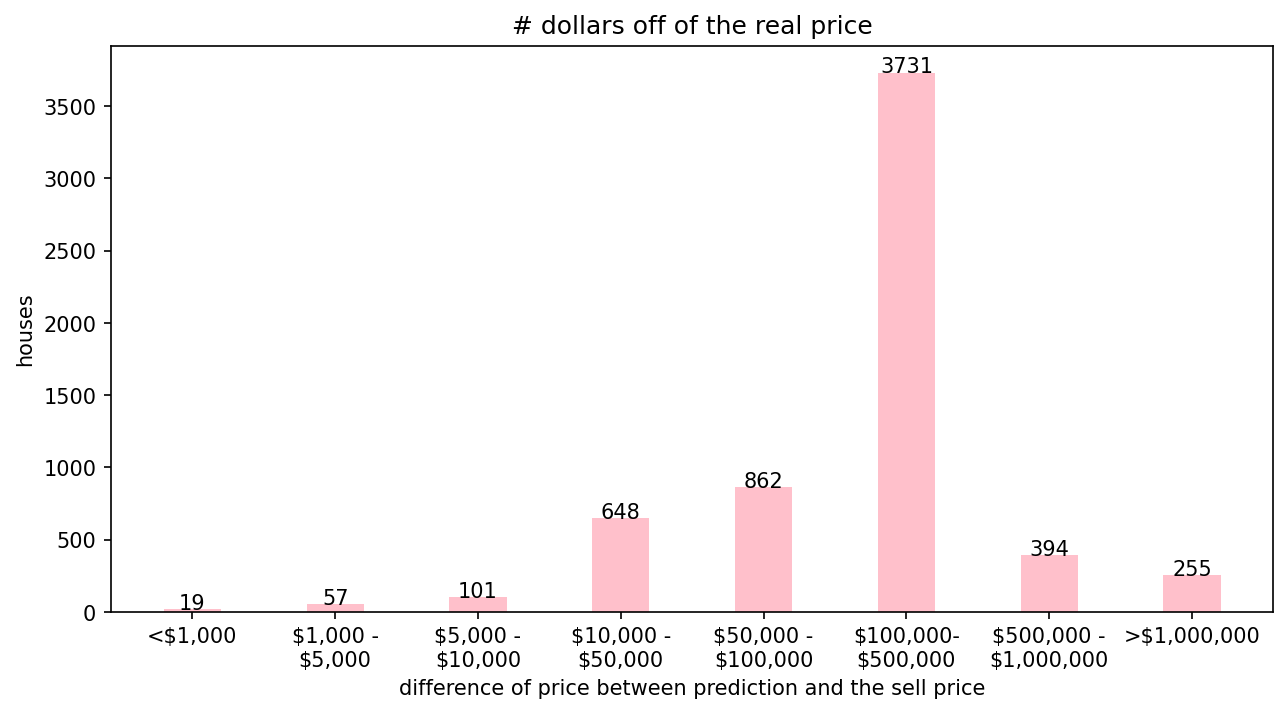

In [46]:
timesGen = [e100,e1000,e5000,e10000,e50000,e100000,e500000,eMillion]
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(tags, timesGen, color ='pink',
        width = 0.4)

for i in range(len(tags)):
    plt.text(i,timesGen[i],timesGen[i],ha='center')
plt.xlabel("difference of price between prediction and the sell price")
plt.ylabel("houses")
plt.title("# dollars off of the real price")
plt.show()

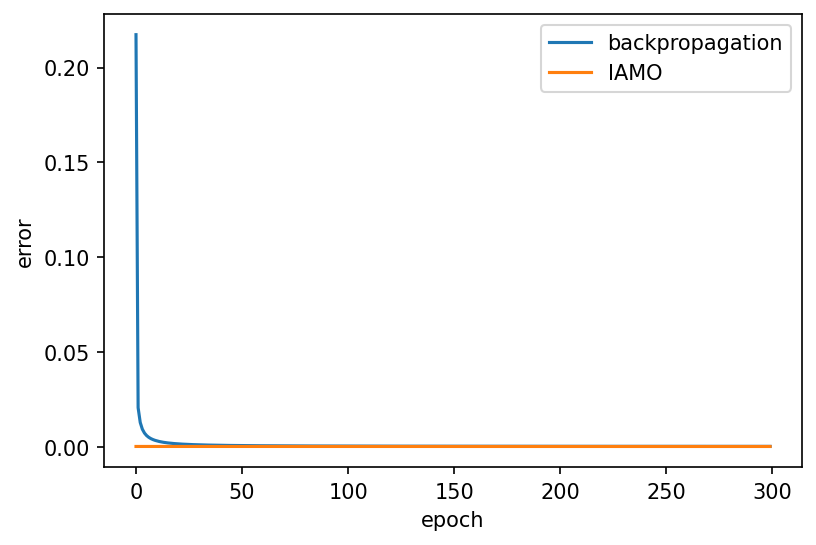

In [47]:
graphError([finalNet,genModel],['backpropagation','IAMO'])

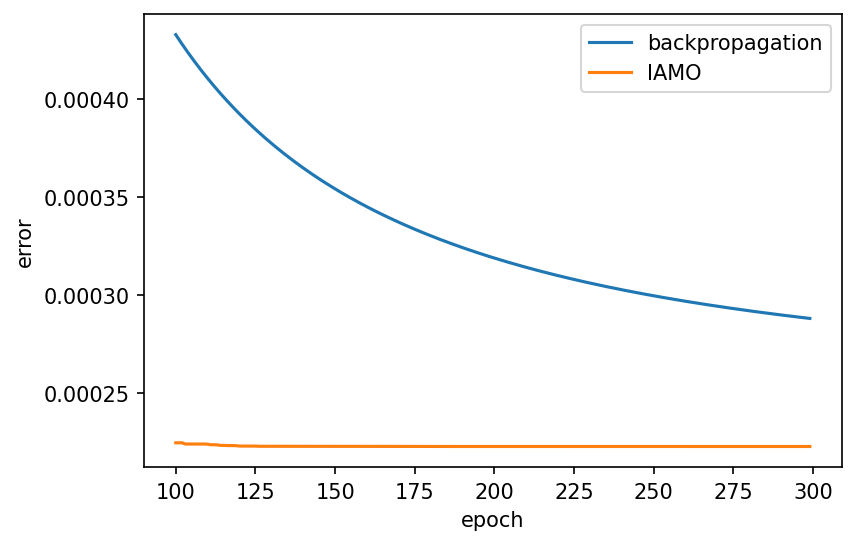

In [48]:
# we are going yo remove the first 100 epochs so we can see more closely the behaviour of the error graph
backPropagationError=finalNet.errorTimeline[100:]
iamoError=genModel.errorTimeline[100:]
x = range(100,len(finalNet.errorTimeline))
plt.plot(x,backPropagationError,label="backpropagation")
plt.plot(x,iamoError,label="IAMO")
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

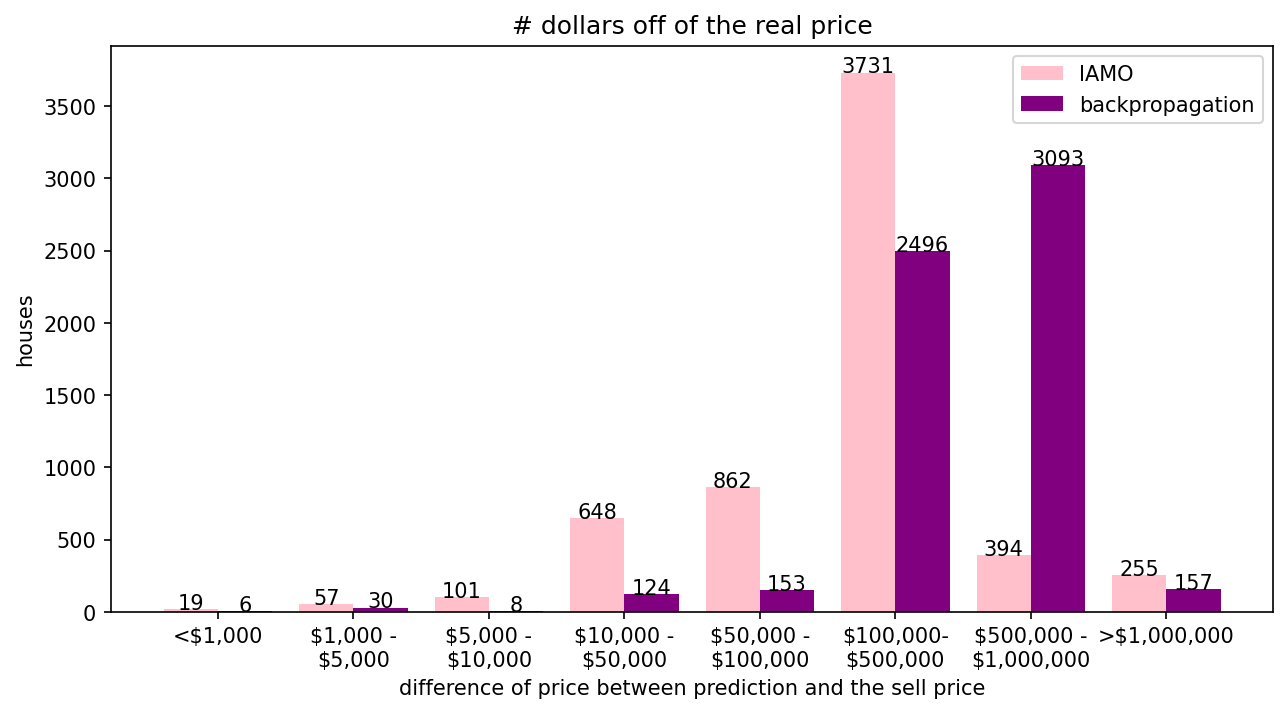

In [49]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
_tags = np.arange(len(tags))
plt.bar(_tags-0.2, timesGen, color ='pink',width = 0.4,label='IAMO')
plt.bar(_tags+0.2, timesBP, color ='purple',width = 0.4,label="backpropagation")
plt.xticks(_tags, tags) # set labels manually
for i in range(len(tags)):
    plt.text(i-0.2,timesGen[i],timesGen[i],ha='center')
for i in range(len(tags)):
    plt.text(i+0.2,timesBP[i],timesBP[i],ha='center')
plt.legend()
plt.xlabel("difference of price between prediction and the sell price")
plt.ylabel("houses")
plt.title("# dollars off of the real price")
plt.show()

We can see that the IAMO net predicts the house price a lot better than the backpropagation net. but we also see that the IAMO net tends to overvalue more houses by more than a million dollars than the backpropagation one, this might be because being 7.4% off (as we saw previously) of the real price on a house that cost millions of dollar gives us that kind of results as such we are going to create a confusion matrix to see how the house price impact how off the prediction is

In [50]:
def matrixValue(i):
    if i<1000:
        return 0
    if(i<5000):
        return 1
    if(i<10_000):
        return 2
    if(i<50_000):
        return 3
    if(i<100_000):
        return 4
    if(i<500_000):
        return 5
    if(i<1_000_000):
        return 6
    return 7

def printMatrix(matrix):
    fig, ax = plt.subplots()
    plt.grid(False)
    plt.imshow(matrix, interpolation='nearest',extent=[0,8,8,0])
    plt.rcParams['axes.grid'] = False 
    ax.xaxis.set_ticks_position("top")
    ax.locator_params(integer=True)
    plt.xlabel("error in the guess price range")
    plt.ylabel("real price")
    plt.xticks(np.arange(0, 8, 1)+0.5,np.arange(0, 8, 1))
    plt.yticks(np.arange(0, 8, 1)+0.5,np.arange(0, 8, 1))
    plt.colorbar()
    plt.text(0, 9, 'The number in the rows represents the range in which the house cost fits', fontsize = 9)
    plt.text(0, 9.5, 'The number in the column represents the range of the error of the prediction', fontsize = 9)
    plt.text(0, 10, '0: <$1,000', fontsize = 9)
    plt.text(0, 10.5, '1: \$1,000 - $5,000', fontsize = 9)
    plt.text(0, 11, '2: \$5,000 - $10,000', fontsize = 9)
    plt.text(0, 11.5, '3: \$10,000 - $50,000', fontsize = 9)
    plt.text(0, 12, '4: \$50,000 - $100,000', fontsize = 9)
    plt.text(0, 12.5, '5: \$100,000 - $500,000', fontsize = 9)
    plt.text(0, 13, '6: \$500,000 - $1,000,000', fontsize = 9)
    plt.text(0, 13.5, '7: >$,1,000,000', fontsize = 9)
    plt.show()
    
def confusionMatrix(net,X,Y):
    matrix = np.zeros((8,8),dtype=int)
    predictions=net.predict(X)
    for pred,price in zip(predictions,Y):
        realPrice = (maxPrice-minPrice)*price.item()+minPrice
        predictedPrice = (maxPrice-minPrice)*pred.item()+minPrice
        i = matrixValue(realPrice)
        j = matrixValue(abs(predictedPrice-realPrice))
        matrix[i][j]+=1
    printMatrix(matrix)

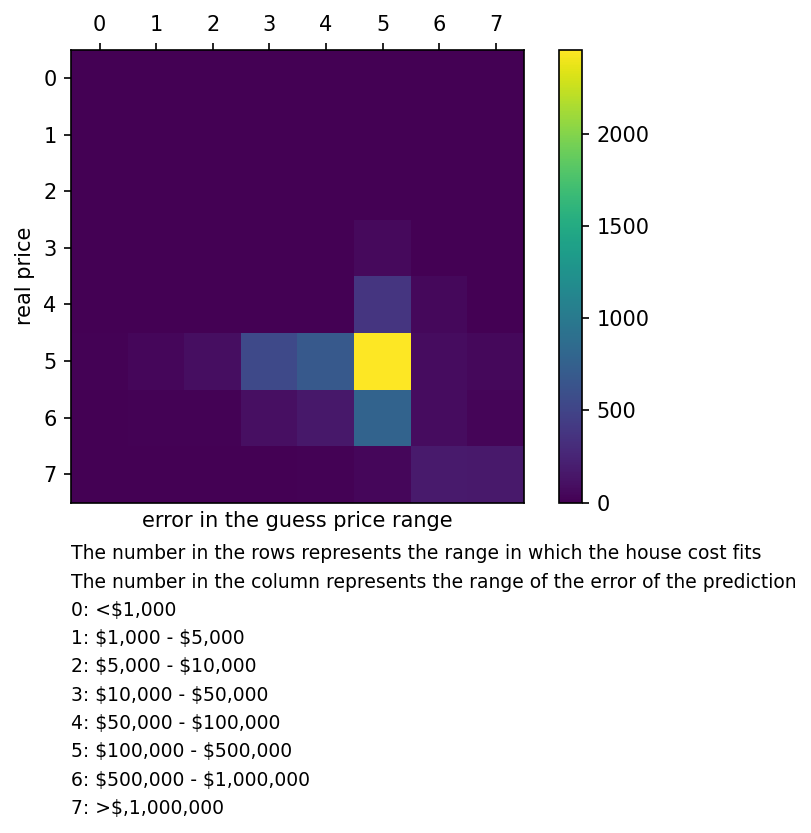

In [51]:
confusionMatrix(genModel,tstX,tstY)

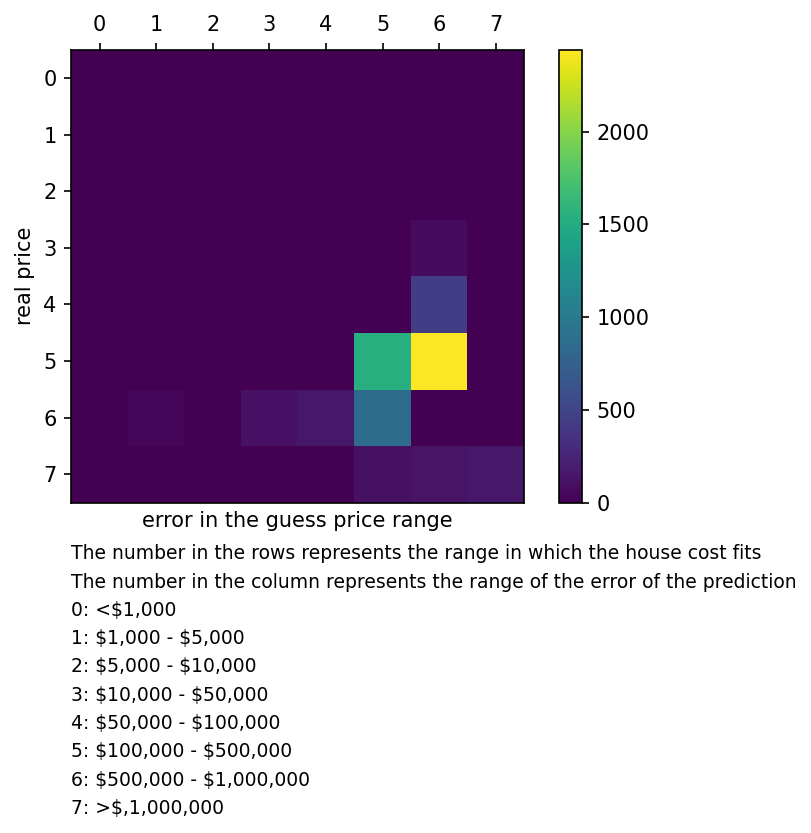

In [52]:
confusionMatrix(finalNet,tstX,tstY)

As we can see the genetic model improves mainly on the houses around \$100,000 to \$500,000 guessing more close to the real price there, but you can faintly see that it overvalues some times with more than a million dollars of error, which for a house that costs between \$100,000 - \$500,000 thats a hefty error.
So in conclusion we get better results from the genetic model (even though is slower from training) but the network sometimes overvalues cheap houses, so a good solution would be to take the prices of both nets for that range of houses (given that the backpropagation net doesnt overvalue those range of houses), so if the genetic net gives a really highprice and the backpropagation gives a low price we trust more the backpropagation one otherwise we trust more the genetic one, with that we can get an even better result 